# A Gentle Introduction to Buffer Stock Saving 

This notebook explores the behavior of a consumer identical to the perfect foresight consumer described in [Gentle-Intro-To-HARK-PerfForesightCRRA](https://econ-ark.org/materials/Gentle-Intro-To-HARK-PerfForesightCRRA) except that now the model incorporates income uncertainty.

In [1]:
# This cell has just a bit of initial setup. You can click the triangle to the left to expand it.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
import matplotlib.pyplot as plt

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

## Changes to the model

Specifically, our new type of consumer receives two income shocks at the beginning of each period: a completely transitory shock $\theta_t$ and a completely permanent shock $\psi_t$.  Moreover, lenders set a limit on borrowing: The ratio of end-of-period assets $A_t$ to permanent income $P_t$ must be less greater than $\underline{a} \leq 0$. As with the perfect foresight problem, this model can be framed in terms of _normalized_ variables, e.g. $m_t \equiv M_t/P_t$.  (See [here](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/) for all the theory).

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} U(c_t) + \beta (1 - \mathsf{D}_{t+1}) \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& R/(\Gamma_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_t,\theta_t) \sim F_{t}, &\qquad& \mathbb{E} [F_{\psi t}] = [F_{\theta t}] = 1, \\
U(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

The simplest assumption (and therefore the default choice in $\texttt{IndShockConsumerType}$) is that the transitory and permanent shocks are independent.  The permanent shock is assumed to be lognormal, while the transitory shock has two components: A probability $\wp$ that the consumer is unemployed, in which case $\theta=\underline{\theta}$, and a probability $(1-\wp)$ of a shock that is a lognormal with a mean chosen so that $\mathbb{E}_{t}[\theta_{t+n}]=1$.

The $\texttt{IndShockConsumerType}$ inherits all of the parameters of the original $\texttt{PerfForesightConsumerType}$ class.  Given the assumptions above, we need to specify the extra parameters to specify the income shock distribution and the artificial borrowing constraint. As before, we'll make a dictionary:


| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\underline{a}$ | Artificial borrowing constraint | $\texttt{BoroCnstArt}$ | 0.0 |
| $\sigma_\psi$ | Underlying stdev of permanent income shocks | $\texttt{PermShkStd}$ | 0.1 |
| $\sigma_\theta^{e}$ | Underlying stdev of transitory income shocks | $\texttt{TranShkStd}$ | 0.1 |
| $N_\psi$ | Number of discrete permanent income shocks | $\texttt{PermShkCount}$ | 7 |
| $N_\theta$ | Number of discrete transitory income shocks | $\texttt{TranShkCount}$ | 7 |
| $\mho$ | Unemployment probability | $\texttt{UnempPrb}$ | 0.05 |
| $\underline{\theta}$ | Transitory shock when unemployed | $\texttt{IncUnemp}$ | 0.3 |

HARK represents agents with this kind of problem as instances of the class $\texttt{IndShockConsumerType}$.  To create a $\texttt{IndShockConsumerType}$ instance, we only need to define an artificial borrowing constraint $\underline{a}$ and a sequence of income shock distributions $\{F_t\}$. It's easy enough to pick a borrowing constraint-- say, $\underline{a} = 0$ so that the consumer cannot borrow at all.

In [2]:
# This cell defines a parameter dictionary for making an instance of IndShockConsumerType.

IndShockDictionary = {
    'PermShkStd': [0.1],  # ... and the new parameters for constructing the income process.    
    'PermShkCount': 7,
    'TranShkStd': [0.1],
    'TranShkCount': 7,
    'UnempPrb': 0.05,
    'IncUnemp': 0.3,
    'BoroCnstArt': 0.0,
    
    'cycles' : 0 # infinite time horizon -- see below
}
        
# Hey, there's a lot of parameters we didn't tell you about!  Yes, but you don't need to
# think about them for now.

Though we can override them if we like, it's simpler to use default values provided by HARK. The `PerfForesightConsumerType` class has many of these attributes already.

You can see all the **attributes** of an object in Python by using the `dir()` command. You can see that many of the model variables are now attributes of this object, along with many other attributes that are outside the scope of this tutorial.

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType

pfc = PerfForesightConsumerType()
dir(pfc)

['AgentCount',
 'BoroCnstArt',
 'CRRA',
 'DiscFac',
 'LivPrb',
 'MaxKinks',
 'PermGroFac',
 'PermGroFacAgg',
 'RNG',
 'Rfree',
 'T_age',
 'T_cycle',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aNrmInitMean',
 'aNrmInitStd',
 'addToTimeInv',
 'addToTimeVary',
 'assignParameters',
 'cFunc_terminal_',
 'checkConditions',
 'checkElementsOfTimeVaryAreLists',
 'checkRestrictions',
 'clearHistory',
 'cycles',
 'delFromTimeInv',
 'delFromTimeVary',
 'distance',
 'getAvg',
 'getControls',
 'getMortality',
 'getPostStates',
 'getRfree',
 'getShocks',
 'getStates',
 'initializeSim',
 'makeShockHistory',
 'pLvlInitMean',
 'pLvlInitStd',
 'postSolve',
 'poststate_

`IndShockConsumerType` is a **superclass** of `PerfForesightConsumerType`. This means that it builds on the functionality of the other type. You can find the superclasses of a type in Python using the `__bases__` attribute.

In [4]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

IndShockConsumerType.__bases__

(HARK.ConsumptionSaving.ConsIndShockModel.PerfForesightConsumerType,)

In [5]:
IndShockExample = IndShockConsumerType(**IndShockDictionary)

As before, we need to import the relevant subclass of $\texttt{AgentType}$ into our workspace, then create an instance by passing the dictionary to the class as if the class were a function.

## Discretizing probability distributions

Computers are discrete devices; even if somehow we knew with certainty that the distributions of the transitory and permanent shocks were, say, continuously lognormally distributed, in order to be represented on a computer those distributions would need to be approximated by a finite and discrete set of points.  A large literature in numerical computation explores ways to construct such approximations; probably the easiest example to understand is the equiprobable approximation, in which the continuous distribution is represented by a set of $N$ outcomes that are equally likely to occur. 

In the case of a single variable (say, the permanent shock $\psi$), and when the number of equiprobable points is, say, 5, the procedure is to construct a list: $psi_{0}$ is the mean value of the continuous $\psi$ given that the draw of $\psi$ is in the bottom 20 percent of the distribution of the continuous $\psi$.  $\\psi_{1}$ is the mean value of $\psi$ given that the draw is between the 20th and 40th percentiles, and so on.  The expectation of some expression $f(\psi)$ can be very quickly calculated by:

$$ 
\mathbb{E}_{t}[f(\psi)] \approx (1/N) \sum_{i=0}^{N-1} f(\psi_{i})
$$

In principle, any smooth multivariate continuous distribution can be approximated to an arbitrary degree of accuracy with a fine enough matrix of points and their corresponding probailities.  This is, in fact, the fundamental way that HARK represents uncertainty: By a specifying a multidimensional array containing joint probabilities of the realizations of the shocks.

The scatterplot below shows how the discretized probability distribution is represented in HARK. The lognormal distribution is represented by a set of equiprobable point masses.

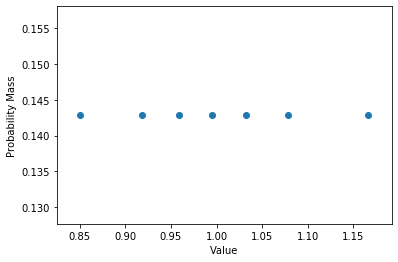

In [6]:
plt.scatter(IndShockExample.PermShkDstn[0][1],
            IndShockExample.PermShkDstn[0][0])
plt.xlabel("Value")
plt.ylabel("Probability Mass")
plt.show()

Notice that this distribution was created when the `IndShockConsumerType` object was initialized, but it was not an attribute you gave it directly.

## Backwards Induction

HARK will solve this problem using _backwards induction_.

It will derive a solution for each period ($t$) by choosing the optimal policy mapping from market resources $m$ to consumption $c$. This function will be stored in a variable named `cFunc`.

Backwards induction requires a "terminal" (last, final) period to work backwards from. Our `IndShockExample` has been initialized with a terminal solution. There are many functions wrapped together in the solution object, which is of type `ConsumerSolution`.

In [7]:
IndShockExample.solution_terminal

The consumption function `cFunc` is define by _linear interpolation_.
It is defined by a series of $(x,y)$ points on a grid; the value of the function for any $x$ is the $y$ determined by the line between the nearest defined gridpoints.
You can see below that in the terminal period, $c = m$; the agent consumes all available resources.

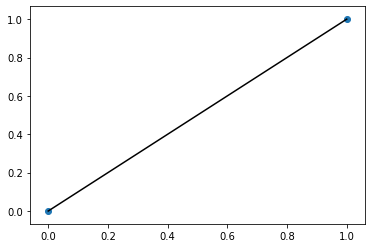

In [8]:
plt.plot(IndShockExample.solution_terminal.cFunc.x_list,
         IndShockExample.solution_terminal.cFunc.y_list,
         color='k')
plt.scatter(IndShockExample.solution_terminal.cFunc.x_list,
            IndShockExample.solution_terminal.cFunc.y_list)

The solution also has a representation of a `value function`, the value `v(m)` as a function of available market resources. Because the agent consumes all their resources in the last period, the value function for the terminal solution looks just like the CRRA utility function.

/home/sb/projects/econ-ark/HARK/HARK/utilities.py:141: RuntimeWarning: divide by zero encountered in reciprocal
  return( c**(1.0 - gam) / (1.0 - gam) )


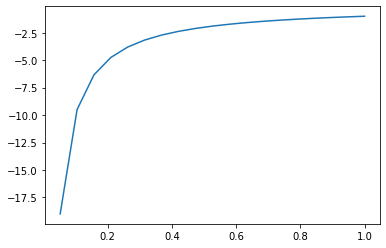

In [9]:
x = np.linspace(0,1,20)
plt.plot(x,
        IndShockExample.solution_terminal.vFunc(x))

If these are the consumption and value functions for the _last_ period, what are the functions for the _first_ period?

Recall that we are solving this problem on the _infinite time horizon_; in other words, there is no "first period".

In [10]:
IndShockExample.cycles

0

What we will do instead is perform backwards induction until the consumption and value functions _converge_. We will see that this derived consumption function looks quite different from the terminal solution.

## Solving the problem

Now we can solve our new agent's problem just like before, using the $\texttt{solve}$ method.

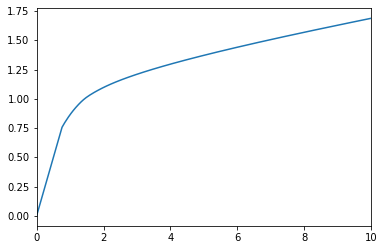

In [11]:
IndShockExample.solve()
plotFuncs(IndShockExample.solution[0].cFunc,0.,10.)

This solution was generated by running a **method** that is an attribute of the `IndShockExample` object. Many methods in Python have a description, called its **documentation**, that will tell you what it does and what its arguments are. You can read the documentation for methods and other attributes in HARK with the built-in Python `help()` function.

In [12]:
help(IndShockExample.solve)

Help on method solve in module HARK.core:

solve(verbose=False) method of HARK.ConsumptionSaving.ConsIndShockModel.IndShockConsumerType instance
    Solve the model for this instance of an agent type by backward induction.
    Loops through the sequence of one period problems, passing the solution
    from period t+1 to the problem for period t.
    
    Parameters
    ----------
    verbose : boolean
        If True, solution progress is printed to screen.
    
    Returns
    -------
    none



## Changing Constructed Attributes

In the parameter dictionary above, we chose values for HARK to use when constructing its numeric representation of $F_t$, the joint distribution of permanent and transitory income shocks. When $\texttt{IndShockExample}$ was created, those parameters ($\texttt{TranShkStd}$, etc) were used by the **constructor** or **initialization** method of $\texttt{IndShockConsumerType}$ to construct an attribute called $\texttt{IncomeDstn}$.

Suppose you were interested in changing (say) the amount of permanent income risk.  From the section above, you might think that you could simply change the attribute $\texttt{TranShkStd}$, solve the model again, and it would work.

That's _almost_ true-- there's one extra step. $\texttt{TranShkStd}$ is a primitive input, but it's not the thing you _actually_ want to change. Changing $\texttt{TranShkStd}$ doesn't actually update the income distribution... unless you tell it to (just like changing an agent's preferences does not change the consumption function that was stored for the old set of parameters -- until you invoke the $\texttt{solve}$ method again).  In the cell below, we invoke the method $\texttt{updateIncomeProcess}$ so HARK knows to reconstruct the attribute $\texttt{IncomeDstn}$.

In [13]:
OtherExample = deepcopy(IndShockExample)  # Make a copy so we can compare consumption functions
OtherExample.PermShkStd = [0.2]           # Double permanent income risk (note that it's a one element list)
OtherExample.updateIncomeProcess()        # Call the method to reconstruct the representation of F_t
OtherExample.solve()

In the cell below, use your blossoming HARK skills to plot the consumption function for $\texttt{IndShockExample}$ and $\texttt{OtherExample}$ on the same figure.

In [14]:
# Use the line(s) below to plot the consumptions functions against each other